## Welcome to Behavioral Cloning

### 1. Data Collection & Augmentation

In [1]:
import csv
import os
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from scipy import ndimage
import matplotlib.pyplot as plt
import random

#### Using a Generator

In [2]:
samples = []
with open('/home/carnd/TrainData/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
print(len(samples))

9526


In [3]:
def generator(samples, batch_size):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        #shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                current_path = '/home/carnd/TrainData/IMG/'+batch_sample[0].split('/')[-1]
                image = ndimage.imread(current_path)
                measurement = float(batch_sample[3])
                images.append(image)
                measurements.append(measurement)
            # trim image to only see section with road
            augmented_images, augmented_measurements = [],[]
            for image,measurement in zip(images,measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

In [4]:
## Data Collection and Train/Test 80/20 Split

train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(len(train_samples))
print(len(validation_samples))

batch_size = len(samples)
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)
ch, row, col = 160, 320, 3  # Trimmed image format

7620
1906


#### Not Using a Generator

In [ ]:
##DATA COLLECTION
lines = []
with open('/home/carnd/TrainData/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
                lines.append(line)

images = []
measurements = []

for line in lines:
        source_path = line[0]
        filename = source_path.split('/')[-1]
        current_path = '/home/carnd/TrainData/IMG/' + filename
        #image = cv2.imread(current_path)
        image = ndimage.imread(current_path)
        images.append(image)
        measurement = float(line[3])
        measurements.append(measurement)

In [ ]:
##DATA AUGMENTATION
augmented_images, augmented_measurements = [],[]
for image,measurement in zip(images,measurements):
        augmented_images.append(image)
        augmented_measurements.append(measurement)
        augmented_images.append(cv2.flip(image,1))
        augmented_measurements.append(measurement*-1.0)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

### A little bit of Data Exploration

#### Not Using a Generator

In [ ]:
print(len(X_train))
indice = random.randint(0, len(X_train))
plt.figure(figsize=(1,1))
plt.imshow(X_train[indice].squeeze())
plt.show()
print(format(X_train[indice].shape))
print(y_train[indice])

#### Using a Generator

15240
3812
7620
1906
<class 'list'>
<class 'list'>
<class 'generator'>
<class 'list'>
<class 'numpy.ndarray'>
(15240, 160, 320, 3)
(160, 320, 3)
-0.1566185
<class 'generator'>
<class 'list'>
<class 'numpy.ndarray'>
(3812, 160, 320, 3)
(160, 320, 3)


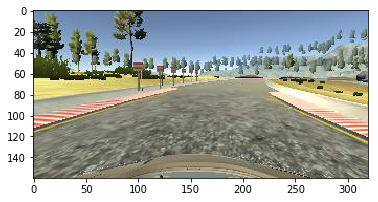

In [5]:
indice = random.randint(0, len(next(validation_generator)[0]))

print(len(next(train_generator)[0]))
print(len(next(validation_generator)[0]))

print(len(train_samples))
print(len(validation_samples))
print(type(train_samples))
print(type(validation_samples))

print(type(train_generator))
print(type(next(train_generator)))
print(type(next(train_generator)[0]))
print(format(next(train_generator)[0].shape))
print(format(next(train_generator)[0][indice].shape))
print((next(train_generator)[1][indice]))

print(type(validation_generator))
print(type(next(validation_generator)))
print(type(next(validation_generator)[0]))
print(format(next(validation_generator)[0].shape))
print(format(next(validation_generator)[0][indice].shape))

plt.imshow((next(train_generator)[0][indice]))
plt.show()

### 2. Model Definition and Training

In [6]:
##IMPORT LIBRARIES
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D

Using TensorFlow backend.


#### Not Using Generator

In [ ]:
##PREPROCESSING
ch, row, col = 160, 320, 3  # Trimmed image format
model  = Sequential()
model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(ch,row,col)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

#### Using Generator

In [7]:
###GENERATOR TECHNIQUE PREPROCESSING
model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(ch, row, col),output_shape=(ch, row, col)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

#### LeNet Model

In [ ]:
#LENET

model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

#### Nvidia Team Model

In [8]:
##NVIDIA

model.add(Convolution2D(24,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="elu"))
model.add(Convolution2D(64,3,3,activation="elu"))
model.add(Convolution2D(64,3,3,activation="elu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

#### Fitting Without Generator

In [ ]:
model.compile(loss='mse', optimizer ='adam')
model.fit(X_train,y_train, validation_split = 0.2, shuffle = True,nb_epoch=5)
model.save('model2.h5')

#### Fitting With Generator

In [9]:
from keras import optimizers

adam = optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=adam)
history_object = model.fit_generator(train_generator, samples_per_epoch= len(next(train_generator)[0]), 
                                     validation_data=validation_generator, 
                                     nb_val_samples=len(next(validation_generator)[0]), 
                                     nb_epoch=8, 
                                     verbose=1)

model.save('model_generator.h5')

Epoch 1/8


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py", line 429, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-3-11bb4ad1bd50>", line 23, in generator
    X_train = np.array(augmented_images)
MemoryError



MemoryError: 

In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()